In [1]:
import json
import pydotplus as pdp
from IPython.display import Image  
from glob import glob

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Convert the dot files to json for the demo.

In [2]:
for f in glob("f*/*.dot"):
    
    graph = pdp.graphviz.graph_from_dot_file(f)

    edges = sorted([(int(e.get_source()), int(e.get_destination())) for e in graph.get_edge_list()])
    nodes = sorted([int(n.get_label()) for n in graph.get_node_list() if n.get_label()])

    j = []
    for n in nodes:
        j.append({"id" : n, "nei" : []})
        for e in edges:
            if n in e:
                j[-1]["nei"].append(e[0] if e[1] == n else e[1])
                
    with open(f.replace("dot", "json"), "w") as out:
        json.dump(j, out)

This is just a closure check, that I "retrieve" the right diagrams.

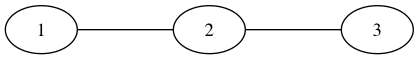

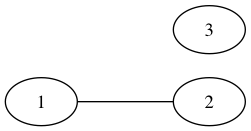

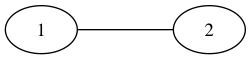

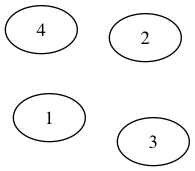

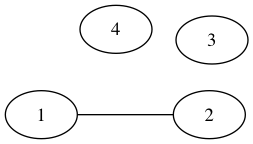

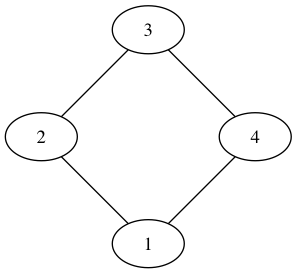

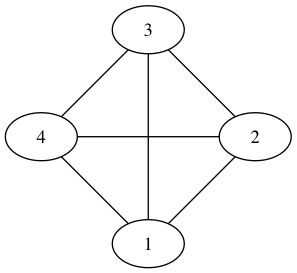

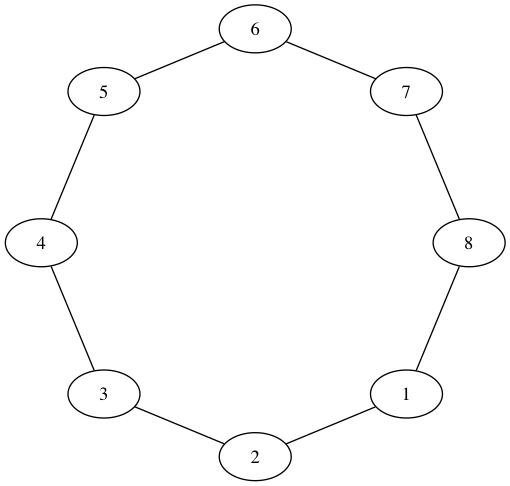

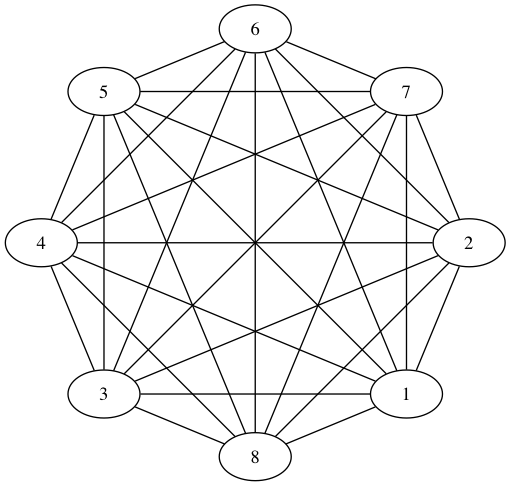

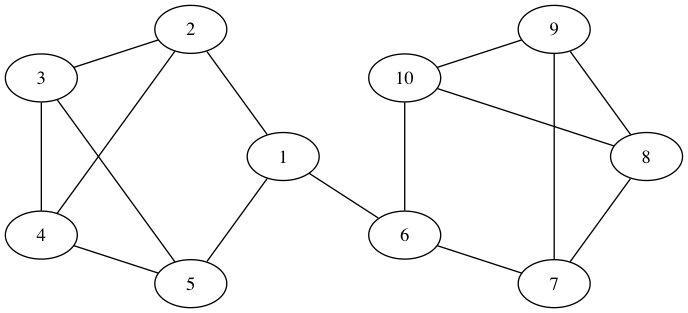

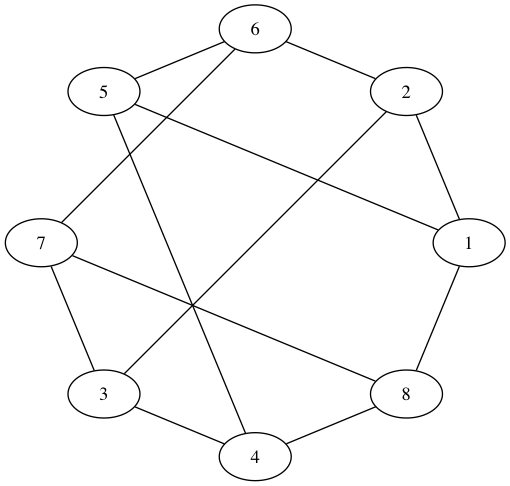

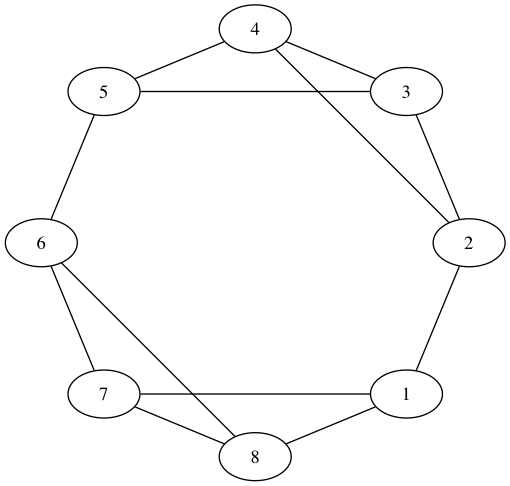

In [3]:
for f in glob("f*/*.json"):
    
    graph = pdp.Dot(graph_type='graph')

    with open(f) as i: 
        j = json.load(i)
        
    nodes = []
    for n in j:
        nodes.append(pdp.Node(str(n["id"])))
        graph.add_node(nodes[-1])

    for n in j:
        for e in n["nei"]:
            if e < n["id"]: continue
            graph.add_edge(pdp.Edge(nodes[e-1], nodes[n["id"]-1]))
        
        
    Image(graph.create_png(prog = "circo"))

In [ ]:
for f in glob("f*/*.dot"):
    
    graph = pdp.graphviz.graph_from_dot_file(f)
    Image(graph.create_png(prog = "neato"))